## Exploring polysemy with BERT embeddings

`BERT` model produces high-quality embeddings for words and sentences depending on their context. The goal is to explore such embeddings and look at them in WSD (Word Sense Disambiguation) task for Russian language. WSD — "is the problem of determining which sense (meaning) of a word is activated by the use of the word in a particular context, a process which appears to be largely unconscious in people".

## Loading

We will use `tranformers` library to explore `BERT` embeddings.

In [1]:
!pip install transformers

In [2]:
import torch
import numpy as np
import logging
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
% matplotlib inline 
plt.style.use('ggplot')

## Working with datasets

I've decided to use data from the [Shared Task on Word Sense Induction and Disambiguation for the Russian Language](https://russe.nlpub.org/2018/wsi/). There are three datasets: [wiki-wiki](https://github.com/nlpub/russe-wsi-kit/tree/master/data/main/wiki-wiki), [bts-rnc](https://github.com/nlpub/russe-wsi-kit/tree/master/data/main/bts-rnc) and [active-dict](https://github.com/nlpub/russe-wsi-kit/tree/master/data/main/active-dict). The summary table about these datasets is below:
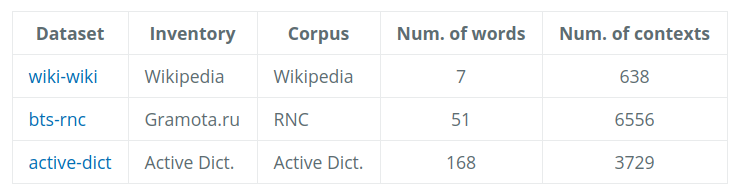

Let's use the data from this [source](https://github.com/nlpub/russe-wsi-kit/tree/master/data/main) and have a look at the its format (it is the same for all datasets).

In [3]:
import pandas as pd

In [4]:
url_wiki = 'https://raw.githubusercontent.com/nlpub/russe-wsi-kit/master/data/main/wiki-wiki/train.csv'
url_bts = 'https://raw.githubusercontent.com/nlpub/russe-wsi-kit/master/data/main/bts-rnc/train.csv'
url_active = 'https://raw.githubusercontent.com/nlpub/russe-wsi-kit/master/data/main/active-dict/train.csv'

df_wiki = pd.read_csv(url_wiki, sep='\t', error_bad_lines=False)
df_bts = pd.read_csv(url_bts, sep='\t', error_bad_lines=False)
df_active = pd.read_csv(url_active, sep='\t', error_bad_lines=False)

In [5]:
df_wiki.sample(20)

,context_id,word,gold_sense_id,predict_sense_id,positions,context
385,386,бор,1,NaN,"68-71, 141-144, 179-182, 277-280, 309-312, 341...","с большим выделением теплоты , образуется окси..."
4,5,замок,1,NaN,"134-139, 262-267",великий князь литовский гедимин после успешной...
187,188,лук,1,NaN,"12-15, 49-52, 178-181, 228-231, 358-361, 405-408",композитный лук главное достоинство композитно...
255,256,суда,1,NaN,283-287,конституционном суде российской федерации отме...
278,279,суда,1,NaN,"28-32, 66-70, 113-117",военная коллегия верховного суда ссср военная ...
120,121,замок,2,NaN,"253-258, 427-432",дужку изготавливают - см длины . зародившаяся...
394,395,бор,1,NaN,"62-65, 186-189, 273-276, 381-384, 452-455",номером . обозначается символом b ( ) . в своб...
355,356,суда,2,NaN,164-168,"собственные сердитое ( № ) , бурное ( № ) и ..."
105,106,замок,2,NaN,"228-233, 514-519",защиты от пожаров . много интересного изобрете...
378,379,суда,2,NaN,239-243,и добирались до берегов северной америки . kno...


In [6]:
text_columns = ['word', 'context']

## Tokenization and formatting

We could do tokenization in a manual way, but let's use a function `encode_plus`, provided by the `BertTokenizer` class from `tranformers` library to perform desired tokenization of input text. It will return a dictionary containing PyTorch tensors: `input_ids` — ids in vocabulary of tokens from the text, `token_type_ids` (or segment ids) — ids indicating the first and the second sentence in the input (in our case we will have only one sentence) and `attention_mask`.



In [7]:
# !pip install git+https://github.com/kmike/pymorphy2.git

In [8]:
# !pip install -U pymorphy2-dicts-ru

In [9]:
# import pymorphy2
# import nltk

# nltk_tokenizer = nltk.tokenize.WordPunctTokenizer()
# morph = pymorphy2.MorphAnalyzer(path='/usr/local/lib/python3.6/dist-packages/pymorphy2_dicts_ru/data', lang='ru')

In [10]:
# def normalize(text):
#     text = str(text.lower())
#     tokenized_text = nltk_tokenizer.tokenize(text)
#     return ' '.join([morph.parse(word)[0].normal_form for word in tokenized_text])

In [11]:
# df_wiki[text_columns] = df_wiki[text_columns].applymap(normalize)
# df_bts[text_columns] = df_bts[text_columns].applymap(normalize)
# df_active[text_columns] = df_active[text_columns].applymap(normalize)

In [12]:
test_text = 'При движении вдоль кривой в окрестности заданной точки соприкасающаяся плоскость вращается, причём касательная к кривой является мгновенной осью этого вращения.'

In [13]:
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

In [14]:
encoded_dict = tokenizer.encode_plus(test_text, 
                                     add_special_tokens=True,
                                     padding=True,
                                     return_attention_mask=True,
                                     return_tensors='pt')

In [15]:
encoded_dict

{'input_ids': tensor([[   101,   2790,  24386,  16066,  28078,  15484,    845,  36473, 109954,
           1438,    852,  13562,  71573,  27287,  58376,  62188,    128,  20320,
          13086,  22998,    861,  28078,  15484,   4415,  50940,    852,  84726,
           4638,  32102,    132,    102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1]])}

## Extracting embeddings for each layer

### Exploring structure of embeddings

Let's have a look at embeddings, which we have from the `BertModel`.

In [16]:
# loading pre-trained model
model = BertModel.from_pretrained('DeepPavlov/rubert-base-cased',
                                  output_hidden_states = True)

model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [17]:
# running the text throught BERT and collect all hidden states from 12 layers
with torch.no_grad():
    outputs = model(encoded_dict['input_ids'], encoded_dict['token_type_ids'])
    hidden_states = outputs[2]

The `hidden_states` object has four dimensions in the following order:


1.   The layer number
2.   The batch number
3.   The token number
4.   The hidden feature number

Let's look at it.



In [18]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 31
Number of hidden units: 768


We want our tensor to be in dimensions: `[#tokens, #layers, #features]`. So, let's perform this operations with a tensor.

In [19]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 31, 768])

In [20]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 31, 768])

In [21]:
# Swap dimensions 0 and 1 to get dimensions [#tokens, #layers, #features]
token_embeddings = token_embeddings.permute(1, 0, 2)

token_embeddings.size()

torch.Size([31, 13, 768])

### Function combining text tokenization and embeddings extraction for a sentence

Let's combine the process of tokenization and extracting embeddings in one function for a single input (sentence).

In [22]:
def encode_and_extract_embeddings(model, tokenizer, text):
    model.eval()

    encoded_dict = tokenizer.encode_plus(text, 
                                         add_special_tokens=True,
                                         padding=True,
                                         return_attention_mask=True,
                                         return_tensors='pt')
    
    with torch.no_grad():
        outputs = model(encoded_dict['input_ids'], encoded_dict['token_type_ids'])
        hidden_states = outputs[2]
    
    token_embeddings = torch.stack(hidden_states, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    token_embeddings = token_embeddings.permute(1, 0, 2)
    return token_embeddings

In [23]:
# testing of the function above
tok_emb = encode_and_extract_embeddings(model, tokenizer, test_text)
tok_emb.size()

torch.Size([31, 13, 768])

## Creating word embeddings by combining layer vectors

There are several approaches to combining embeddings received from the layers of `BERT`. Let's use some of them to get the only one vector for the specific word.

In [24]:
# Concatenate the last four layers to get token embeddings
def concatenate_n_last_layers(token_embeddings):
    token_vecs_cat = []

    for token in token_embeddings:
        cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
        token_vecs_cat.append(cat_vec)
        
    return token_vecs_cat

In [25]:
# Sum the last four layers to get token embeddings
def sum_last_n_layers(token_embeddings):
    token_vecs_sum = []

    for token in token_embeddings:
        sum_vec = torch.sum(token[-4:], dim=0)
        token_vecs_sum.append(sum_vec)
        
    return token_vecs_sum

## Testing embedding vectors

### Processing datasets

Let's create a function, which processes one of the datasets and returns embeddings and corresponding words and contexts.

In [26]:
def process_dataset(dataset, combining_way='concatenate'):
    context_embeddings = []
    words = []
    contexts = []
    gold_sense_ids = []
    for i in range(len(dataset)):
        word = dataset.iloc[i]['word']
        context = dataset.iloc[i]['context']
        gold_sense_id = dataset.iloc[i]['gold_sense_id']

        token_embeddings = encode_and_extract_embeddings(model, tokenizer, context)
        if combining_way == 'concatenate':
            token_vecs = concatenate_n_last_layers(token_embeddings)
        if combining_way == 'sum':
            token_vecs = sum_last_n_layers(token_embeddings)

        word_token_list = tokenizer.tokenize(word)
        context_token_list = tokenizer.tokenize(context)
        index_array = [idx for idx, s in enumerate(context_token_list) if word_token_list[0][:3] in s]

        if index_array:
            index = index_array[0]
            words.append(word)
            contexts.append(context)
            gold_sense_ids.append(gold_sense_id)
            context_embeddings.append(np.asanyarray(token_vecs[index]))
        
    return context_embeddings, words, contexts, gold_sense_ids

The function below allows to get the bounds of consecutive words in a dataset. It will be useful for visualization.

In [27]:
def get_bounds_of_diff_words(words):
    a = [words[i] != words[i+1] for i in range(len(words) - 1)]
    bounds_indices = [0]
    b = np.where(a)[0] + 1
    bounds_indices.extend(b)
    return bounds_indices

In [28]:
%%time
emb_wiki_concat, words_wiki_concat, contexts_wiki_concat, gsi_wiki_concat = process_dataset(df_wiki, combining_way='concatenate')
emb_wiki_sum, words_wiki_sum, contexts_wiki_sum, gsi_wiki_sum = process_dataset(df_wiki, combining_way='sum')

CPU times: user 6min 10s, sys: 21.1 s, total: 6min 32s
Wall time: 6min 32s


In [29]:
%%time
emb_bts, words_bts, contexts_bts, gsi_bts = process_dataset(df_bts)

CPU times: user 11min 28s, sys: 18.7 s, total: 11min 46s
Wall time: 11min 48s


In [30]:
%%time
emb_active, words_active, contexts_active, gsi_active = process_dataset(df_active)

CPU times: user 4min 11s, sys: 7.94 s, total: 4min 19s
Wall time: 4min 20s


In [31]:
bounds_wiki = get_bounds_of_diff_words(words_wiki_concat)
bounds_bts = get_bounds_of_diff_words(words_bts)
bounds_active = get_bounds_of_diff_words(words_active)

### Visualization preparation

Let's make an interactive visualization, which will allow us to walk through the embedding space and explore correspoding contexts of words.

In [32]:
from IPython.display import clear_output

In [33]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.models.annotations import Title
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, word, radius=10, alpha=0.25, color='cornflowerblue',
                 width=600, height=400, show=True, **kwargs):
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)
    t = Title()
    t.text = 'Embedding vectors for the word \'{}\''.format(word)
    fig.title = t

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

### UMAP visualization

In [34]:
import umap

In [35]:
def umap_visualize(emb_vectors, words, contexts, words_bounds, word_number=1):
    embeddings = umap.UMAP(n_neighbors=5).fit_transform(emb_vectors[words_bounds[word_number - 1]:words_bounds[word_number]])
    draw_vectors(embeddings[:, 0], embeddings[:, 1], words[words_bounds[word_number - 1]], token=contexts[words_bounds[word_number - 1]:words_bounds[word_number]])

In [36]:
print('Unique words for wiki-wiki dataset: {}\n'.format(np.unique(df_wiki['word'])))
print('Unique words for bts-rnc dataset: {}\n'.format(np.unique(df_bts['word'])))
print('Unique words for active_dict dataset: {}\n'.format(np.unique(df_active['word'])))

Unique words for wiki-wiki dataset: ['бор' 'замок' 'лук' 'суда']

Unique words for bts-rnc dataset: ['балка' 'вид' 'винт' 'горн' 'губа' 'жаба' 'клетка' 'крыло' 'купюра'
 'курица' 'лавка' 'лайка' 'лев' 'лира' 'мина' 'мишень' 'обед' 'оклад'
 'опушка' 'полис' 'пост' 'поток' 'проказа' 'пропасть' 'проспект' 'пытка'
 'рысь' 'среда' 'хвост' 'штамп']

Unique words for active_dict dataset: ['дар' 'двигатель' 'двойник' 'дворец' 'девятка' 'дедушка' 'дежурная'
 'дежурный' 'декабрист' 'декрет' 'дело' 'демобилизация' 'демократ'
 'демонстрация' 'дерево' 'держава' 'дерзость' 'десятка' 'десяток'
 'деятель' 'диалог' 'диаметр' 'диплом' 'директор' 'диск' 'дичь' 'длина'
 'доброволец' 'добыча' 'доказательство' 'доктор' 'долгота' 'доля' 'дом'
 'дорога' 'достижение' 'древесина' 'дупло' 'дура' 'дух' 'дым' 'дымка'
 'дыхание' 'дьявол' 'евро' 'езда' 'жаворонок' 'жало' 'жертва' 'жестокость'
 'жидкость' 'жила' 'жилец' 'жир' 'жребий' 'заведение' 'завещание'
 'зависимость' 'заголовок' 'заготовка' 'задание' 'задача' '

Let's have a look at UMAP visualization of word embeddings for different words from different datasets.

In [37]:
umap_visualize(emb_active, words_active, contexts_active, bounds_active, word_number=5)

In [38]:
umap_visualize(emb_active, words_active, contexts_active, bounds_active, word_number=1)

In [39]:
umap_visualize(emb_bts, words_bts, contexts_bts, bounds_bts, word_number=28)

We can see that the embeddings for the word 'среда' cluster depending on their contexts in sentences. The number of clusters we see, that are produced by `UMAP`, is not always the same, however, in most cases we are able to identify four clusters.

Here are the examples of the word 'среда' from this dataset and their `gold_sense_ids`, which contain the correct sense identifier. 

In [40]:
df_bts[df_bts['word'] == 'губа'][['word', 'gold_sense_id', 'context']].sample(25)

,word,gold_sense_id,context
389,губа,1,"либо заведующего, чтобы тянул. Ох, тяжелая эта..."
479,губа,1,вдруг будто обиделся Ивашка. -- Да ты не обижа...
414,губа,1,"рассердился, но отобрал у него карандаш и долг..."
376,губа,1,"тридцать! -- услышал я те слова, которые на ул..."
463,губа,1,"- Стоит, стоит. Иначе никогда человеком не ста..."
443,губа,1,взглянул и испугался: лицо ее покрывала смертн...
459,губа,1,"и была очень голодной, взяла ее из рук так ост..."
491,губа,1,себя слушать еще внимательней. Сновала сюда-об...
429,губа,1,"более чем реальной, совершенно белые глаза его..."
400,губа,1,"mieux pour vous, tant pis pour les autres», --..."


We also see that there are four different `gold_sense_ids`.

Let's have a look at the embeddings for the same word, which were obtained by defferent ways of combining layer vectors.

In [41]:
umap_visualize(emb_wiki_concat, words_wiki_concat, contexts_wiki_concat, bounds_wiki, word_number=1)

In [42]:
umap_visualize(emb_wiki_sum, words_wiki_sum, contexts_wiki_sum, bounds_wiki, word_number=1)

### t-SNE

In [43]:
from sklearn.manifold import TSNE

In [44]:
def tsne_visualize(emb_vectors, words, contexts, words_bounds, word_number=1):
    embeddings = TSNE().fit_transform(emb_vectors[words_bounds[word_number - 1]:words_bounds[word_number]])
    draw_vectors(embeddings[:, 0], embeddings[:, 1], words[words_bounds[word_number - 1]], token=contexts[words_bounds[word_number - 1]:words_bounds[word_number]])

In [45]:
tsne_visualize(emb_bts, words_bts, contexts_bts, bounds_bts, word_number=28)

For `t-SNE` plot it is harder to determine the clusters, maybe it is due to its inner parameters (like `perplexity`), which should be carefully selected. Anyway, we can see that the most distant regions of the plot correspond to different contexts (среда — (1) день недели; (2) некое окружение, обстановка; (3) вещество, заполняющее пространство).

## Clustering exploration

Clustering algorithms may produce labels for clusters in the different order and numeration comparing to actual `gold_sense_ids` in our datasets. There is a function in which we iterate through all possible permutations of target labels, map them to predictions and validate using `Adjusted Rand Index` and `Adjusted Mutual Information`.

In [46]:
import itertools
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

def validate_clustering(preds, target):
    print('ARI: {:.3f}'.format(adjusted_rand_score(target, preds)))
    print('AMI: {:.3f}\n'.format(adjusted_mutual_info_score(target, preds)))

Let's use the extracted embeddings of one word from one dataset for clustering exploration.

### KMeans

In [47]:
from sklearn.cluster import KMeans

In [48]:
kMeans = KMeans(n_clusters=4)
preds_kmeans = kMeans.fit_predict(emb_bts[bounds_bts[27]:bounds_bts[28]])

In [49]:
validate_clustering(preds_kmeans, gsi_bts[bounds_bts[27]:bounds_bts[28]])

ARI: 0.420
AMI: 0.422



### EM-algorithm

In [50]:
from sklearn.mixture import GaussianMixture

EM_cluster = GaussianMixture(n_components=4)
preds_em = EM_cluster.fit_predict(emb_bts[bounds_bts[27]:bounds_bts[28]])

In [51]:
validate_clustering(preds_em, gsi_bts[bounds_bts[27]:bounds_bts[28]])

ARI: 0.380
AMI: 0.425



### Agglomerative Clustering

#### Testing algorithm for a specific word in `bts-rnc` dataset

In [52]:
from sklearn.cluster import AgglomerativeClustering

In [53]:
aggl_cl = AgglomerativeClustering(n_clusters=4, linkage='complete')
preds_aggl = aggl_cl.fit_predict(emb_bts[bounds_bts[27]:bounds_bts[28]])

In [54]:
validate_clustering(preds_aggl, gsi_bts[bounds_bts[27]:bounds_bts[28]])

ARI: 0.428
AMI: 0.441



#### Comparison of concatenated and summed embeddings

Let's numerically compare embeddings, which were obtained by concatenation of the four last layers and by summing the last four layers. We made them for `wiki-wiki` dataset.

We will look at the embeddings of the word `замок`. It has two `gold_sense_ids` due to the dataset.

In [55]:
aggl_cl_compare = AgglomerativeClustering(n_clusters=2, linkage='complete')

In [56]:
preds_sum = aggl_cl_compare.fit_predict(emb_wiki_sum[bounds_wiki[0]:bounds_wiki[1]])
preds_concat = aggl_cl_compare.fit_predict(emb_wiki_concat[bounds_wiki[0]:bounds_wiki[1]])

In [57]:
def plot_emb(embeddings_type_1, embeddings_type_2, gsi_type_1, gsi_type_2,
             preds_type_1, preds_type_2, type_1, type_2):
    plt.figure(figsize=(20, 12))

    emb_umap_type_1 = umap.UMAP(random_state=42).fit_transform(embeddings_type_1)
    plt.subplot(2, 2, 1)
    plt.title("UMAP visualization of {} embeddings with original labels".format(type_1), fontsize=14)
    plt.scatter(emb_umap_type_1[:, 0], emb_umap_type_1[:, 1], c=gsi_type_1, cmap='Spectral')

    emb_umap_type_2 = umap.UMAP(random_state=42).fit_transform(embeddings_type_2)
    plt.subplot(2, 2, 2)
    plt.title("UMAP visualization of {} embeddings with original labels".format(type_2), fontsize=14)
    plt.scatter(emb_umap_type_2[:, 0], emb_umap_type_2[:, 1], c=gsi_type_2, cmap='Spectral')

    plt.subplot(2, 2, 3)
    plt.title("UMAP visualization of {} embeddings with predicted labels".format(type_1), fontsize=14)
    plt.scatter(emb_umap_type_1[:, 0], emb_umap_type_1[:, 1], c=preds_type_1, cmap='Spectral')

    plt.subplot(2, 2, 4)
    plt.title("UMAP visualization of {} embeddings with predicted labels".format(type_2), fontsize=14)
    plt.scatter(emb_umap_type_2[:, 0], emb_umap_type_2[:, 1], c=preds_type_2, cmap='Spectral')

    plt.show()

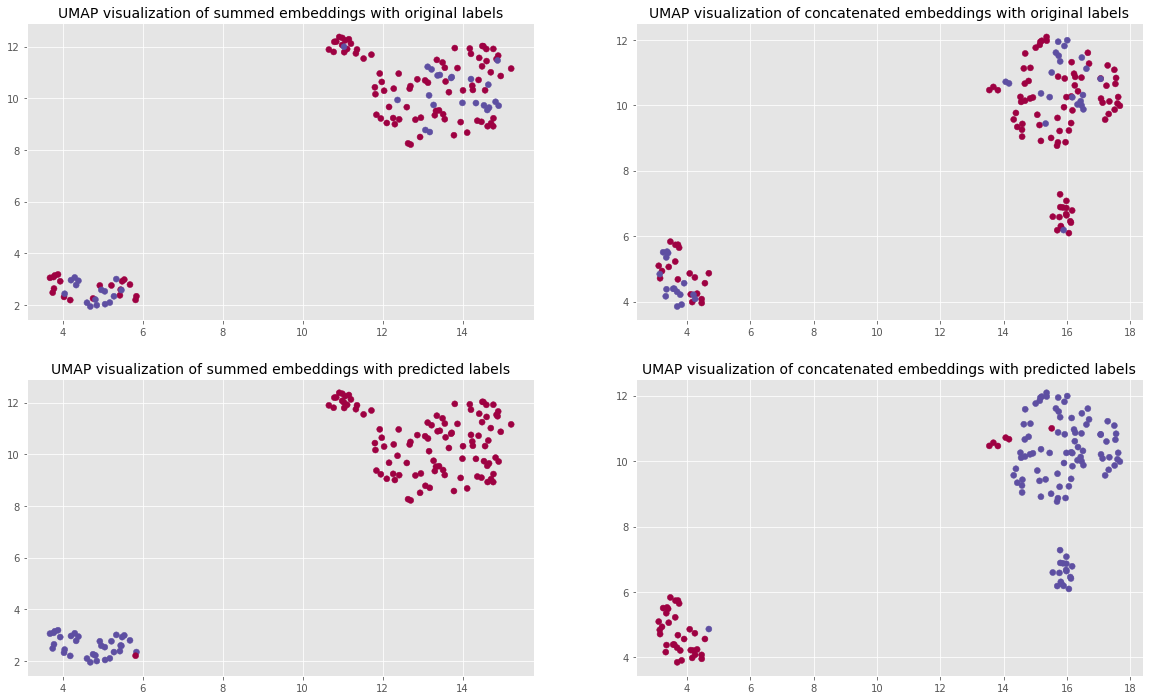

In [58]:
plot_emb(emb_wiki_sum[bounds_wiki[0]:bounds_wiki[1]],
         emb_wiki_concat[bounds_wiki[0]:bounds_wiki[1]],
         gsi_wiki_sum[bounds_wiki[0]:bounds_wiki[1]],
         gsi_wiki_concat[bounds_wiki[0]:bounds_wiki[1]], 
         preds_sum, preds_concat,
         'summed', 'concatenated')

In [59]:
print('Scores for summed embeddings:')
validate_clustering(preds_sum, gsi_wiki_sum[bounds_wiki[0]:bounds_wiki[1]])
print('Scores for concatenated embeddings:')
validate_clustering(preds_concat, gsi_wiki_concat[bounds_wiki[0]:bounds_wiki[1]])

Scores for summed embeddings:
ARI: 0.128
AMI: 0.045

Scores for concatenated embeddings:
ARI: 0.142
AMI: 0.059



We see by the `ARI` and `AMI` metrics that embeddings, which were made by concatenation, showed slightly better results in our task than summed embeddings.

### DBSCAN

#### Non-transformed embeddings or preprocessed?

Let's visualize embeddings staticly with their labels using `UMAP`.

In [60]:
from sklearn.cluster import DBSCAN
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})

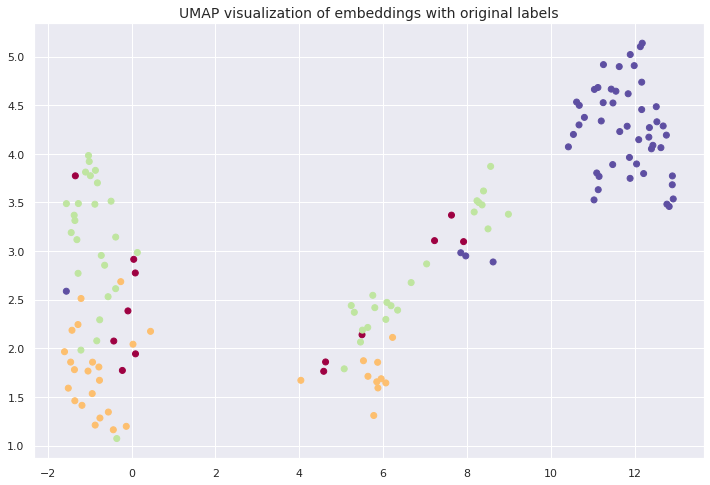

In [61]:
emb_umap = umap.UMAP(random_state=42).fit_transform(emb_bts[bounds_bts[27]:bounds_bts[28]])
plt.title("UMAP visualization of embeddings with original labels", fontsize=14)
plt.scatter(emb_umap[:, 0], emb_umap[:, 1], c=gsi_bts[bounds_bts[27]:bounds_bts[28]], cmap='Spectral')
plt.show()

Let's try applying `UMAP` algorithm to reduce the dimensionality of embeddings in order to use them in density-based clustering method. This approach was explored in the [article](https://umap-learn.readthedocs.io/en/latest/clustering.html), and it seems to be useful in our case.

In [62]:
transformed_embeddings_bts = umap.UMAP(
    n_neighbors=20,
    min_dist=0.0, 
    n_components=5,
).fit_transform(emb_bts[bounds_bts[27]:bounds_bts[28]])

Let's try to determine the best parameter for the $\varepsilon$ in `DBSCAN` by making the plot where on the $y$ axis we have the distance to the $k$-th nearest neighbor, and on the $x$ axis we have the number of points, which have smaller distance to the $k$-th neighbor. The optimal value of $\varepsilon$ corresponds to the maximum curvature on the plot. 

In [63]:
from sklearn.neighbors import NearestNeighbors

In [64]:
 def experiment_k_and_eps(embeddings):
    n_neighbors = range(2, 11)
    fig = plt.figure(figsize=(18, 12))

    for index, k in enumerate(n_neighbors):
        neigh = NearestNeighbors(n_neighbors=k)
        nbrs = neigh.fit(embeddings)
        distances, indices = nbrs.kneighbors(embeddings)
        distances = np.sort(distances, axis=0)
        distances = distances[:, k-1]

        plt.subplot(3, 3, index+1)
        plt.xlabel('Point sorted by the distance to the {}-th nearest neighbor'.format(k-1))
        plt.ylabel('{}-th nearest neighbor distance'.format(k-1))
        plt.plot(distances, color='cornflowerblue')

    plt.show()

We will make the plots both for preprocessed and non-transformed embeddings.

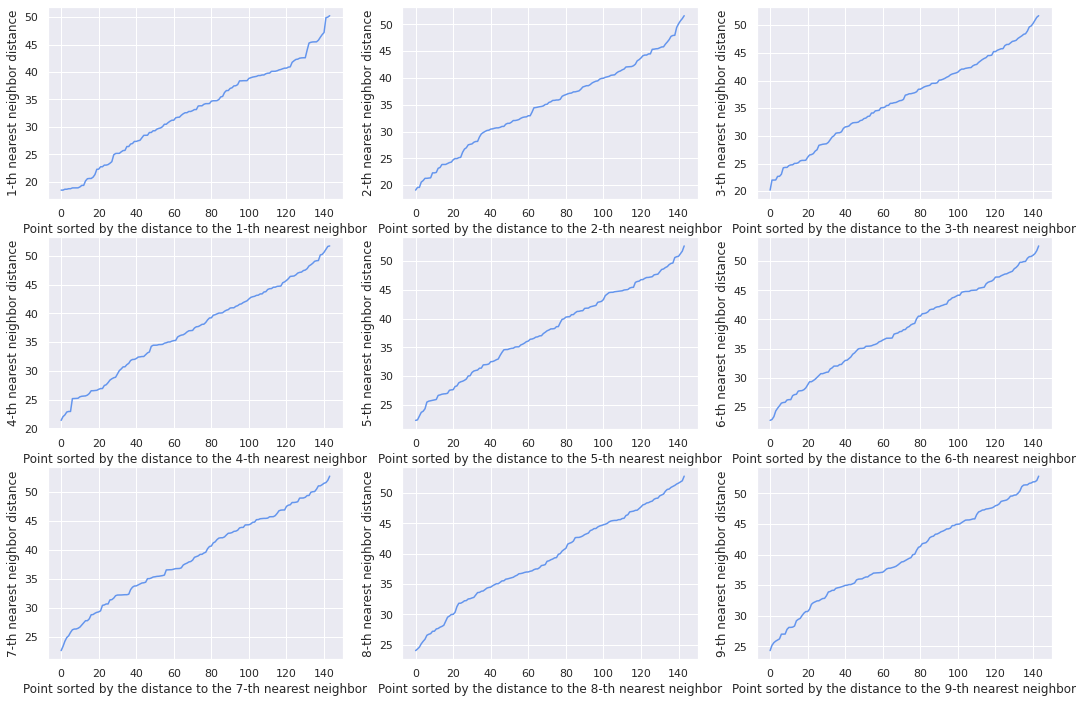

In [65]:
experiment_k_and_eps(emb_bts[bounds_bts[27]:bounds_bts[28]])

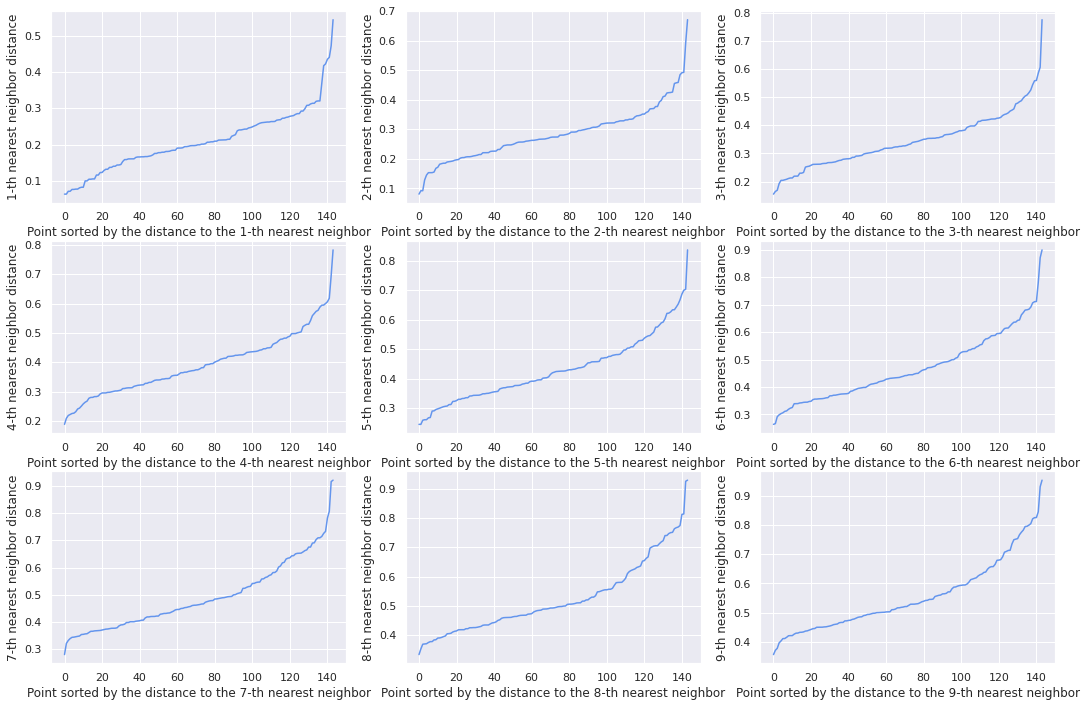

In [66]:
experiment_k_and_eps(transformed_embeddings_bts)

It seems like the best $\varepsilon$ value for transformed embeddings is somewhere in between $0,5$ and $0,7$. For non-transformed embeddings it's hard to see any maximum curvature in the plots, so we will use some value in the middle. Let's apply it in `DBSCAN`.

In [67]:
dbscan = DBSCAN(40)
dbscan_transformed = DBSCAN(0.7)

preds_dbscan = dbscan.fit_predict(emb_bts[bounds_bts[27]:bounds_bts[28]])
preds_dbscan_transformed = dbscan_transformed.fit_predict(transformed_embeddings_bts)

Let's visualize the embedding space with their original labels and with predicted by `DBSCAN` labels.

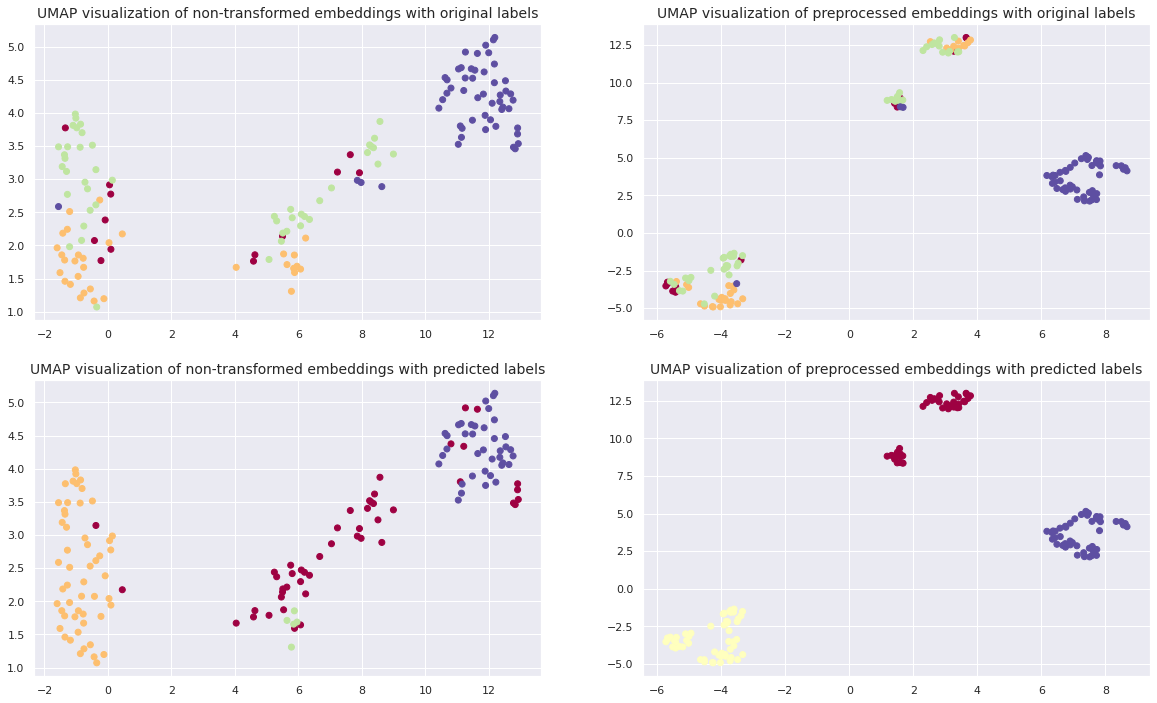

In [68]:
plot_emb(emb_bts[bounds_bts[27]:bounds_bts[28]],
         transformed_embeddings_bts,
         gsi_bts[bounds_bts[27]:bounds_bts[28]],
         gsi_bts[bounds_bts[27]:bounds_bts[28]],
         preds_dbscan, preds_dbscan_transformed,
         'non-transformed', 'preprocessed')

It looks like `DBSCAN` successfully managed to cluster words from the visual point of view, however, the original labels were not distributed the way it should look. I mean that extracted embeddings were not perfectly separated in space by the specific meaning of the word. The `ARI` and `AMI` scores are below.

In [69]:
print("Scores for non-transformed embeddings:")
validate_clustering(preds_dbscan, gsi_bts[bounds_bts[27]:bounds_bts[28]])
print("Scores for preprocessed by UMAP embeddings:")
validate_clustering(preds_dbscan_transformed, gsi_bts[bounds_bts[27]:bounds_bts[28]])

Scores for non-transformed embeddings:
ARI: 0.299
AMI: 0.371

Scores for preprocessed by UMAP embeddings:
ARI: 0.462
AMI: 0.472



We see that preprocessing stage helped to improve the desired metrics quite significantly.

#### Comparison of concatenated and summed embeddings

Let's apply `DBSCAN` for comparison between concatenated and summed embeddings. We will also use `UMAP` as a preprocessing stage for this experiment. 

In [70]:
transformed_embeddings_wiki_sum = umap.UMAP(
    n_neighbors=20,
    min_dist=0.0, 
    n_components=5,
).fit_transform(emb_wiki_sum[bounds_wiki[0]:bounds_wiki[1]])

transformed_embeddings_wiki_concat = umap.UMAP(
    n_neighbors=20,
    min_dist=0.0, 
    n_components=5,
).fit_transform(emb_wiki_concat[bounds_wiki[0]:bounds_wiki[1]])

Let's make plots for different $\varepsilon$ values.

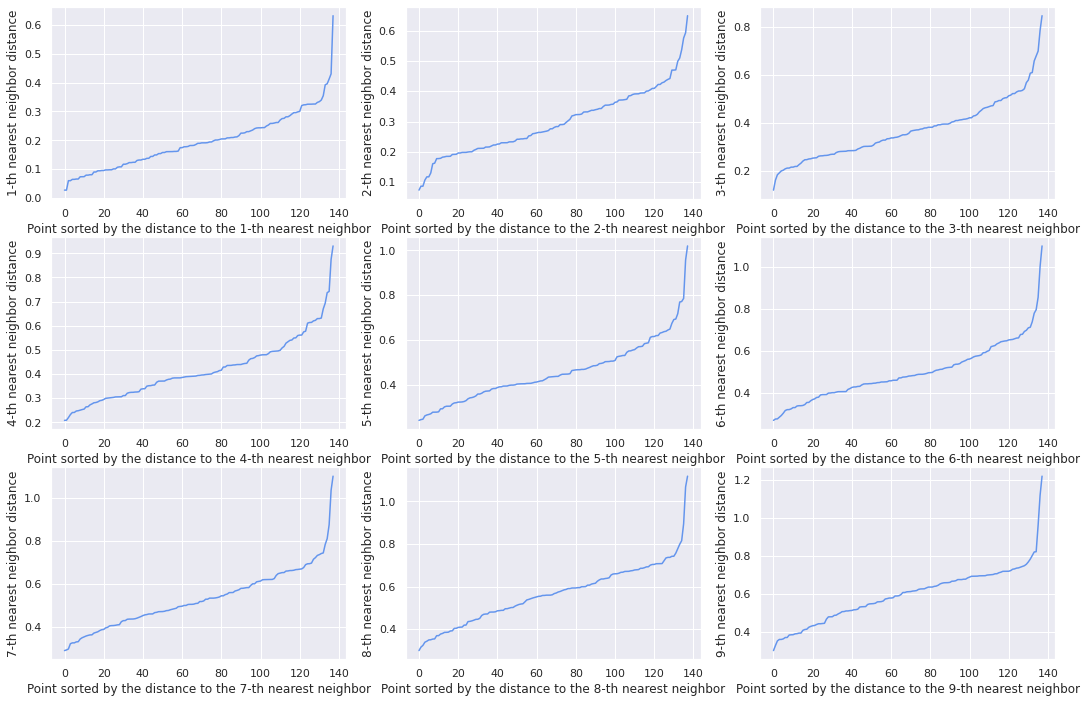

In [71]:
experiment_k_and_eps(transformed_embeddings_wiki_sum)

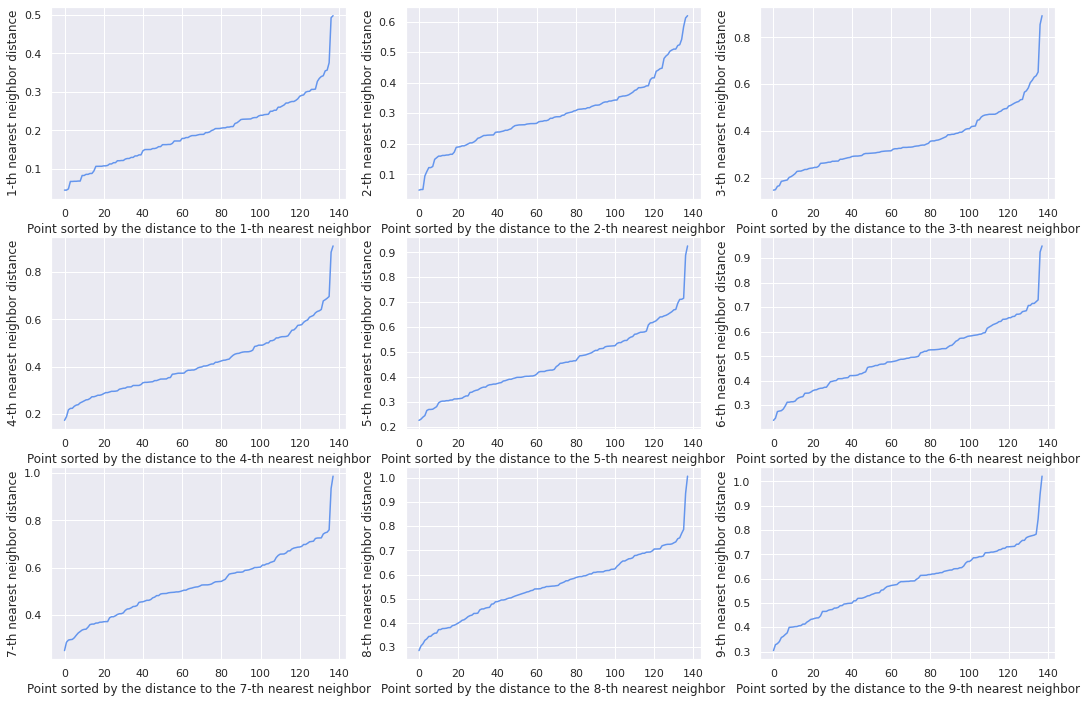

In [72]:
experiment_k_and_eps(transformed_embeddings_wiki_concat)

In [73]:
dbscan_compare = DBSCAN(0.9)
preds_dbscan_sum = dbscan_compare.fit_predict(transformed_embeddings_wiki_sum)
preds_dbscan_concat = dbscan_compare.fit_predict(transformed_embeddings_wiki_concat)

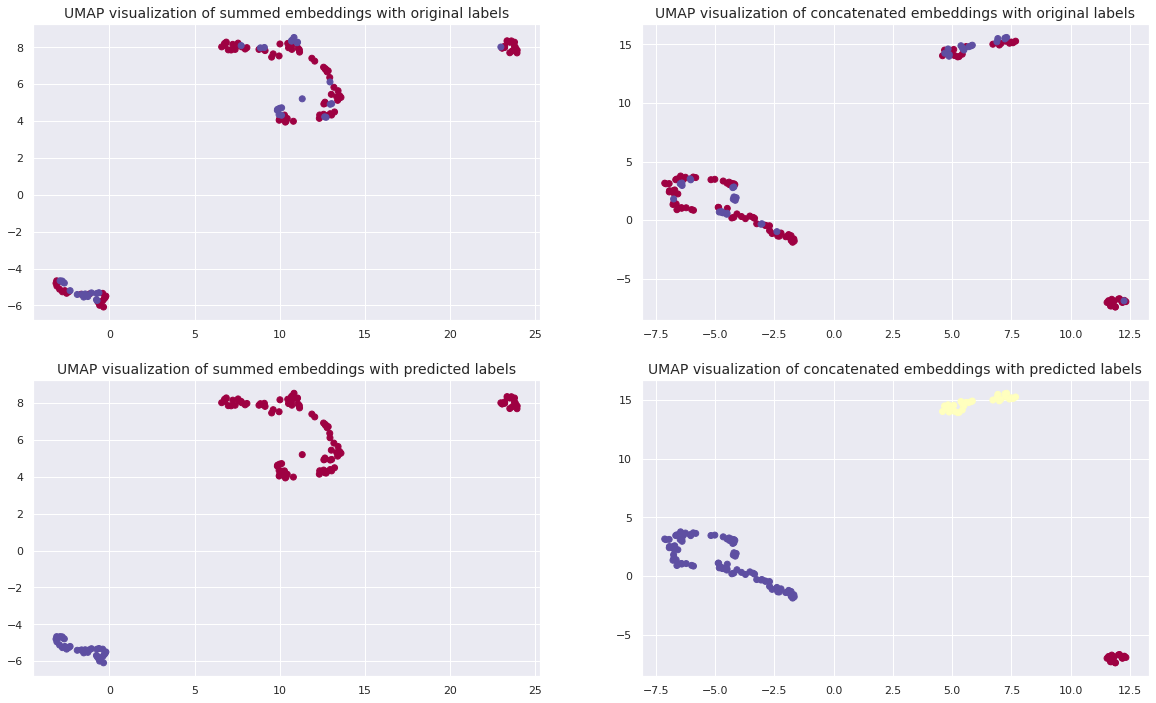

In [74]:
plot_emb(transformed_embeddings_wiki_sum,
         transformed_embeddings_wiki_concat,
         gsi_wiki_sum[bounds_wiki[0]:bounds_wiki[1]],
         gsi_wiki_concat[bounds_wiki[0]:bounds_wiki[1]],
         preds_dbscan_sum, preds_dbscan_concat,
         'summed', 'concatenated')

In [75]:
print('Scores for summed embeddings:')
validate_clustering(preds_dbscan_sum, gsi_wiki_sum[bounds_wiki[0]:bounds_wiki[1]])
print('Scores for concatenated embeddings:')
validate_clustering(preds_dbscan_concat, gsi_wiki_concat[bounds_wiki[0]:bounds_wiki[1]])

Scores for summed embeddings:
ARI: 0.118
AMI: 0.040

Scores for concatenated embeddings:
ARI: 0.033
AMI: 0.044



In this particular example we see that summed embeddings achieved better scores than concatenated.

## Conclusions

General thoughts about `BERT` embeddings:
*   It looks like `BERT` allows to use its embeddings for the words to explore polysemy, get different senses of them depending of their contexts and do some semantic search.
*   However, some  senses of words from datasets are hardly distinguishable even by people, and as we see in examples above `BERT` embeddings sometimes aren't able to catch these differences.
*   It is hard to determine which type of creating word embeddings (concatenation of summation) is always better. It looks like the results are pretty close and they may vary depending on the task and available data. 

Some words about clustering techniques with unknown number of clusters (like `DBSCAN`):
*   The approach for choosing $\varepsilon$ values basing on the plots is quite useful, it allows to get better results.
*   It was helpful to apply `UMAP` algorithm as a preprocessing stage for high-dimensional embeddings. It allowed to impove metrics significantly.

